# Topic Modeling of News Groups

Let's next build a topic model (LDA - Latent Dirichlet Allocation) on the news groups posts from the  <i>YOUR_SCHEMA.twenty_news_groups</i> table to uncover the underlying themes, in an unsupervised fashion. We'll then embed these posts in the topic space and build a classifier.
We'll use NLTK for tokenization.

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [27]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from IPython.display import Image
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

## Approach

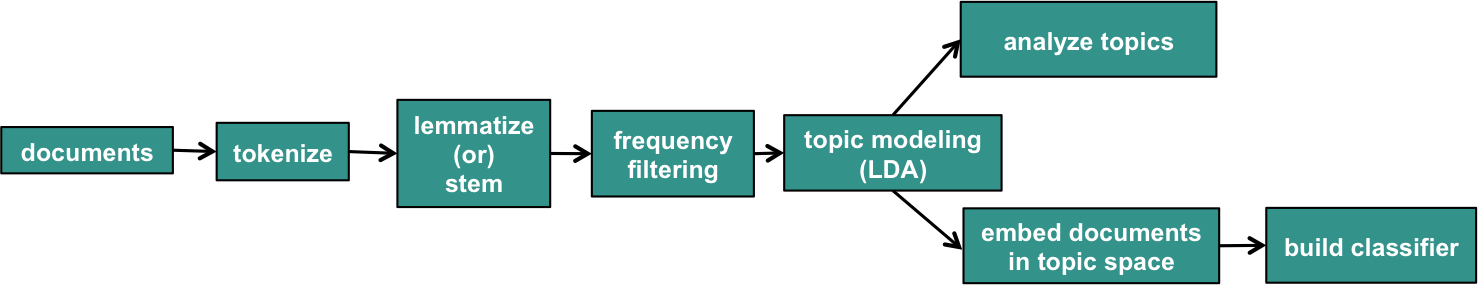

In [3]:
Image(filename='img/topic_analysis_pipeline.png')

In [9]:
sql = """
    select
        *
    from
        YOUR_SCHEMA.twenty_news_groups
    limit 10;
"""
df = psql.read_sql(sql, conn)
conn.commit()
df.head()

doc_id  \
0  3        
1  94       
2  222      
3  313      
4  159      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## 1. Tokenize notes field to run LDA

In [28]:
sql = """
    --1) Create UDF to invoke NLTK's tokenizer
    drop type if exists YOUR_SCHEMA.token_indx_pair cascade;
    create type YOUR_SCHEMA.token_indx_pair
    as
    (
        indx int,
        token text
    );

    drop function if exists YOUR_SCHEMA.word_tokenize_lemmatize(text) cascade;
    create or replace function YOUR_SCHEMA.word_tokenize_lemmatize(doc text)
    returns setof YOUR_SCHEMA.token_indx_pair
    as
    $$
        from unicodedata import category as uc_cat
        from nltk.tokenize import word_tokenize, sent_tokenize
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import stopwords
        import string, re
        
        #discard stopwords
        stop_en = stopwords.words('english')
        
        #Use a wordnet lemmatizer to stem the tokens
        wnl = WordNetLemmatizer()
        
        #tokenize the documents using NLTK
        tokens = [w.strip().decode('utf8') for sent in sent_tokenize(doc) for w in word_tokenize(sent)] if doc else None
        
        if(not tokens):
            return [(0, None),]

        #Remove control characters
        tokens = map(lambda x: ''.join(c for c in x if uc_cat(c) != 'Cc'), tokens)
        
        #Remove punctuations if they are tokens by themselves
        tokens = filter(lambda x: x not in set(list(string.punctuation.decode('utf-8'))), tokens)
        
        #Replace phone numbers with <PHONE>
        phone_pat = re.compile(r'''
                        # don't match beginning of string, number can start anywhere
            (\d{1,2}-?)?
            (\d{3})     # area code is 3 digits (e.g. '800')
            \D*         # optional separator is any number of non-digits
            (\d{3})     # trunk is 3 digits (e.g. '555')
            \D*         # optional separator
            (\d{4})     # rest of number is 4 digits (e.g. '1212')
            \D*         # optional separator
            (\d*)       # extension is optional and can be any number of digits
            $           # end of string
            ''', re.VERBOSE)
        tokens = map(lambda x: u'<PHONE>' if phone_pat.match(x) else x, tokens)
        
        #Replace numbers with <NUM>
        num_pat = re.compile(r'^(-|\+)?(\d*).?(\d+)')
        tokens = map(lambda x: u'<NUM>' if num_pat.match(x) else x, tokens)
        
        #Replace dates
        date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
        tokens = map(lambda x: u'<DATE>' if date_pat.match(x) else x, tokens)
        
        #Remove tokens which are solely composed on non-alpha characters
        non_alpha = re.compile(r'''^(\W+)$''', re.VERBOSE)
        tokens = filter(lambda x: not non_alpha.match(x), tokens)
        
        #Strip out any lingering punctuations now that the document has been tokenized by NLTK
        tokens = map(lambda x: ''.join(c for c in x if not uc_cat(c).startswith('P')), tokens)
        
        #use the wordnet lemmatizer
        lemmatized_tokens = map(lambda x: wnl.lemmatize(x), tokens)
        
        #filter out empty tokens and stopwords
        lemmatized_tokens = filter(lambda x: x and x.strip() and x.strip() not in stop_en, lemmatized_tokens)
        
        #Include unigrams
        unigrams = [indx_tok for indx_tok in enumerate(lemmatized_tokens)] if doc else [(0, None),]
        result = []
        result.extend(unigrams)
        return result
    $$language plpythonu;

    --2) Tokenize the contents field to obtain raw tokens (without frequency filtering)
    drop table if exists twenty_news_groups_tokenized_raw;
    create temp table twenty_news_groups_tokenized_raw
    as
    (
        select
            doc_id,
            (YOUR_SCHEMA.word_tokenize_lemmatize(lower(contents))).*
        from
            YOUR_SCHEMA.twenty_news_groups
    ) distributed by (doc_id);
    
    --3) Filter-out infrequent tokens or tokens occurring in every document (non-informative).
    drop table if exists twenty_news_groups_tokenized_freq_filtered;
    create temp table twenty_news_groups_tokenized_freq_filtered
    as
    (
        select
            t1.token,
            t1.freq as tf,
            t2.num_docs as df,
            t3.total_docs
        from
        (
            select
                token,
                count(*) as freq
            from
                twenty_news_groups_tokenized_raw
            group by token
        ) t1,
        (
            select
                token,
                count(distinct doc_id) as num_docs
            from
                twenty_news_groups_tokenized_raw
            group by token                        
        ) t2,
        (
            select
                count(distinct doc_id) as total_docs
            from
                twenty_news_groups_tokenized_raw
        ) t3
        where
            t1.token = t2.token and
            -- Remove low frequency tokens (make vocabulary size manageable)
            -- by discarding tokens which haven't occurred in atleast 10 documents or has term_freq < 10
            (t2.num_docs > 10 or t1.freq >= 10) and
            -- Remove high-frequency tokens (equivalen to stop-words, uninformative)
            t2.num_docs < 0.98*t3.total_docs
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

#### Examine filtered tokens to identify any more that may have to be added to a custom stopwords list

In [21]:
sql = """
    select
        *
    from
        twenty_news_groups_tokenized_freq_filtered
    order by tf desc
"""
df = psql.read_sql(sql, conn)
conn.commit()
df.head(n=100)

token     tf     df  total_docs
0   ax               61932  67     18846     
1   nt               24406  9463   18846     
2   wa               23689  7910   18846     
3   organization     18884  18132  18846     
4   re               16960  12960  18846     
5   would            15786  7449   18846     
6   m                15148  4997   18846     
7   one              15094  7308   18846     
8   writes           13338  9721   18846     
9   ha               12560  6554   18846     
10  article          11888  8513   18846     
11  like             9636   5934   18846     
12  people           9544   4211   18846     
13  university       9473   7447   18846     
14  doe              9262   5620   18846     
15  know             9249   5789   18846     
16  get              9040   5378   18846     
17  x                8441   922    18846     
18  nntppostinghost  8071   8050   18846     
19  time             7856   4543   18846     
20  u                7788   3329   18846     
21  think            7713   4579   18846     
22  also             7242   4310   18846     
23  use              6616   3587   18846     
24  say              6534   3839   18846     
25  system           6459   3085   18846     
26  could            6451   4177   18846     
27  new              6292   3611   18846     
28  make             6169   3954   18846     
29  good             5955   3784   18846     
..   ...              ...    ...     ...     
70  really           3648   2710   18846     
71  please           3604   2824   18846     
72  number           3579   1910   18846     
73  something        3565   2581   18846     
74  game             3504   1339   18846     
75  since            3495   2561   18846     
76  come             3488   2406   18846     
77  help             3448   2443   18846     
78  believe          3429   2147   18846     
79  day              3428   2200   18846     
80  still            3359   2451   18846     
81  back             3349   2317   18846     
82  o                3328   750    18846     
83  mean             3320   2204   18846     
84  drive            3269   1248   18846     
85  find             3248   2340   18846     
86  email            3232   2426   18846     
87  case             3224   2162   18846     
88  n                3222   605    18846     
89  going            3221   2137   18846     
90  government       3193   1364   18846     
91  look             3183   2235   18846     
92  b                3151   997    18846     
93  information      3136   1735   18846     
94  part             3122   1963   18846     
95  v                3106   1012   18846     
96  w                3089   904    18846     
97  using            3061   2089   18846     
98  might            3020   2247   18846     
99  usa              3000   2622   18846     

[100 rows x 4 columns]

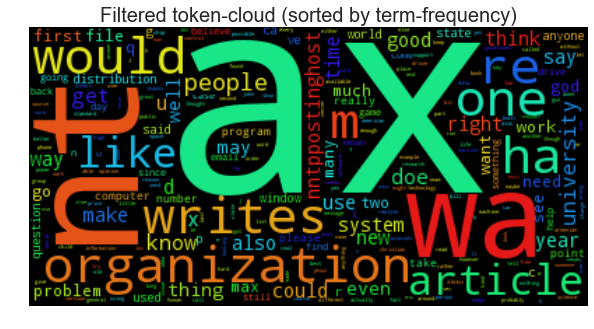

In [22]:
toks = df[['token','tf']].values.tolist()
wordcloud = WordCloud().generate_from_frequencies(toks)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Filtered token-cloud (sorted by term-frequency)', fontsize=20)
plt.show()

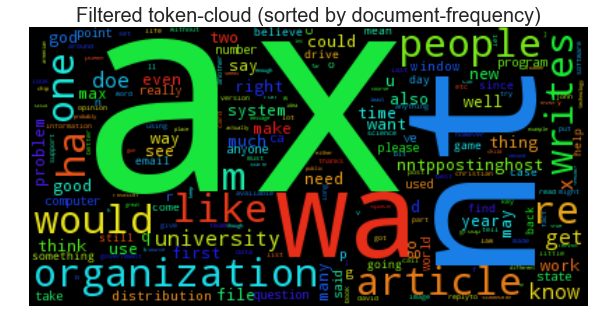

In [23]:
toks = df[['token','df']].values.tolist()
wordcloud = WordCloud().generate_from_frequencies(toks)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Filtered token-cloud (sorted by document-frequency)', fontsize=20)
plt.show()

From the above two tag-clouds (first sorted by term-frequency, second by document frequency), we observe some tokens we can add to a customized domain specific "stopwords list". 

In [29]:
sql = """
    drop table if exists twenty_news_groups_tokenized_domain_stopwords cascade;
    create temp table twenty_news_groups_tokenized_domain_stopwords
    as
    (
        select
            unnest(
                --Domain specific stopwords identified from tag-clouds above
                ARRAY[
                    'would',
                    'nt',
                    'ax',
                    'u',
                    'wa',
                    'said',
                    're',
                    'like',
                    'say',
                    'well',
                    'o',
                    'n',
                    'b',
                    'v',
                    'w',
                    'nntppostinghost'
                ]
            ) as domain_specific_stopword
    ) distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

#### Prepare input table for LDA topic model

Prepare input table for LDA by filtering out domain-specific stopwords, also filter out records whose final bag-of-words is of size zero (because it solely consisted of stopwords or other filtered tokens) 

In [50]:
sql = """
    --1) Create table with infrequent tokens filtered out
    drop table if exists YOUR_SCHEMA.twenty_news_groups_tokenized cascade;
    create table YOUR_SCHEMA.twenty_news_groups_tokenized
    as
    (
        select
            *
        from
        (
            select
                doc_id as docid,
                array_agg(token order by token) as words
            from
            (
                select
                    t1.doc_id,
                    t1.token
                from
                    twenty_news_groups_tokenized_raw t1 
                    inner join
                    twenty_news_groups_tokenized_freq_filtered t2
                    on (t1.token = t2.token)
                    -- Only consider those tokens in t1 that not present in t3
                    left join
                    twenty_news_groups_tokenized_domain_stopwords t3
                    on (t1.token = t3.domain_specific_stopword)
                where
                    -- since we're left joining on t3, we only consider those tokens in t1 which don't exist in t3
                    t3.domain_specific_stopword is null
            )q
            group by docid
        )tbl
        where 
            --discard records which are empty (i.e. all their tokens were filtered out)
            array_upper(words, 1) > 0
    ) distributed by (docid);
    
    --2) LDA input table
    drop table if exists twenty_news_groups_lda_input;
    drop table if exists twenty_news_groups_lda_input_vocabulary;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_input;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_input;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_input_vocabulary;
    select madlib.term_frequency('YOUR_SCHEMA.twenty_news_groups_tokenized', 'docid', 'words', 'twenty_news_groups_lda_input', TRUE);
    create table YOUR_SCHEMA.twenty_news_groups_lda_input as select * from twenty_news_groups_lda_input distributed randomly;
    create table YOUR_SCHEMA.twenty_news_groups_lda_input_vocabulary as select * from twenty_news_groups_lda_input_vocabulary distributed randomly;
"""
psql.execute(sql, conn)
conn.commit()

In [31]:
df = psql.read_sql("""select * from YOUR_SCHEMA.twenty_news_groups_lda_input order by random() limit 10;""", conn)
display(df)
conn.commit()

docid  wordid  count
0  13799  3214    1    
1  17139  17795   1    
2  5258   9049    2    
3  5944   15745   1    
4  1866   5909    2    
5  2293   14858   1    
6  18745  5307    1    
7  14336  22110   1    
8  3889   3069    1    
9  15807  8406    4

## 2. Run LDA on the content field

In [32]:
vocabulary_size = psql.read_sql("""select count(distinct wordid) as voc_size from YOUR_SCHEMA.twenty_news_groups_lda_input""", conn)
display(vocabulary_size)
conn.commit()

voc_size
0  22212

In [34]:
sql = """
drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_mdl cascade;
drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_results cascade;

select 
    madlib.lda_train(
        'YOUR_SCHEMA.twenty_news_groups_lda_input', -- data_table',
        'YOUR_SCHEMA.twenty_news_groups_lda_mdl', -- model_table',
        'YOUR_SCHEMA.twenty_news_groups_lda_results', -- output_data_table',
        {voc_size}, -- voc_size,
        40, -- topic_num,
        50, -- iter_num,
        0.05, -- alpha (recommended = 50/topic_num),
        0.05 -- beta
    );
""".format(
    voc_size = vocabulary_size['voc_size'][0]
)
psql.execute(sql, conn)
conn.commit()

#### LDA Results

#### Model Perplexity

In [35]:
sql = """
    select 
        madlib.lda_get_perplexity( 
            'YOUR_SCHEMA.twenty_news_groups_lda_mdl',
            'YOUR_SCHEMA.twenty_news_groups_lda_results'
        );
"""
df = psql.read_sql(sql, conn)
display(df)
conn.commit()

lda_get_perplexity
0  1873.442717

#### Model Summary

In [36]:
df = psql.read_sql("""select * from YOUR_SCHEMA.twenty_news_groups_lda_mdl;""", conn)
display(df)
conn.commit()
df = psql.read_sql("""select * from YOUR_SCHEMA.twenty_news_groups_lda_results limit 10;""", conn)
display(df)
conn.commit()

voc_size  topic_num  alpha  beta  \
0  22212     40         0.05   0.05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                         model  
0  [0, 1, 0, 5, 1, 8589934592, 0, 0, 0, 0, 0, 12884901888, 2, 4294967296, 8589934592, 0, 0, 0, 0, 0, 0, 17179869184, 0, 3, 0, 0, 0, 0, 0, 0, 34359738405, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 85899345920, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 38654705666, 0, 4294967296, 0, 0, 0, 6, 0, 21, 201863462912, 117, 21474836492, 0, 0, 1, 0, 238, 0, 12, 382252089344, 0, 0, 0, 55834574848, 0, 0, 0, 4294967296, 0, 0, 51539607593, 0, 0, 0, 0, ...]

docid  wordcount  \
0  13     103         
1  141    83          
2  173    91          
3  274    39          
4  402    79          
5  434    93          
6  515    44          
7  46     58          
8  78     211         
9  238    102         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             words  \
0  [6400, 4119, 4824, 15017, 8903, 7395, 8337, 18833, 18243, 4757, 21723, 20845, 7663, 5540, 20337, 11375, 21325, 15529, 17229, 20303, 16389, 5751, 5256, 1162, 8406, 729, 15487, 5429, 530, 8928, 4998, 19612, 8717, 4839, 3565, 21277, 3196, 11962, 18131, 9229, 1843, 12966, 1757, 13957, 2678, 400, 12099, 15205, 2707, 19077, 4980, 8123, 20304, 14205, 6596, 19824, 631, 4862, 6652, 3161, 7937, 8063, 249, 10387, 8071, 22022, 13883, 2934, 11603, 4246, 21187, 18080, 4686, 20483, 1579, 13828, 13186, 10674, 12387, 14994, 2087, 1970, 3770, 18923, 2636]                                                                                                                   
1  [16391, 3804, 6371, 6731, 7170, 10433, 10402, 6928, 8353, 5004, 10423, 7937, 12043, 13957, 19047, 1351, 17042, 21230, 50, 15321, 4751, 4842, 4143, 1568, 5540, 5461, 18604, 20183, 17896, 11083, 4677, 16435, 13183, 14472, 6493, 2915, 18123, 3334, 2213, 18269, 5077, 5873, 20483, 16278, 11875, 15485, 1413, 19317, 3020, 17285, 2551, 3352, 4228, 14533, 12099, 19220, 15444, 1840, 644, 12432, 21731, 12042, 17445, 11978, 22052, 11435, 10985, 10983, 21667, 17604, 14868, 15051]                                                                                                                                                                                           
2  [3685, 3809, 16167, 6667, 11081, 17285, 5794, 9664, 14376, 11055, 1925, 5699, 3637, 1362, 21723, 1162, 18584, 19511, 14846, 863, 14504, 631, 12308, 14950, 12106, 2905, 8085, 9516, 7548, 17444, 570, 3514, 20641, 21646, 12108, 20721, 5135, 15721, 8337, 6593, 18611, 1413, 20416, 6696, 13167, 4847, 8071, 10675, 6180, 8769, 13212, 6073, 8668, 20412, 13957, 4327, 6655, 17992, 6283, 9482, 778, 12359, 13883, 14343, 4040, 6677, 6812, 14297, 11239, 18262, 11628, 7822, 19575, 4338, 5132]                                                                                                                                                                                 
3  [22021, 21723, 6135, 9358, 4763, 10751, 20137, 7490, 11346, 8948, 22140, 6136, 16315, 8071, 6946, 8223, 13957, 4112, 8490, 1162, 21536, 11233, 5540, 7641, 17620, 18774, 18210, 2872, 21667, 10334, 8406, 7415, 11560]                                                                                                                                                                                                                                                                                                                                                                                                                                                            
4  [19525, 18959, 17577, 13957, 6757, 9220, 6375, 3960, 21667, 13107, 16077, 13772, 8102, 914, 13698, 15711, 18340, 15999, 10747, 19677, 13216, 14868, 13108, 21228, 17285, 20682, 7937, 128, 12229, 15925, 16279, 4225, 15993, 5540, 1017, 17514, 7023, 5629, 8803, 765, 3753, 3734, 15876, 16979, 12230, 11357, 14406, 21227, 1555, 18189, 17220, 19543, 4751, 15319, 16389, 3875, 17287, 6230]                                                      

### 3. Topics of interest

#### PCA Projections
Project the topics (represented by probability distribution over words in the vocabulary) into top-2 principal components to identify topics which are most distinct from each other, then we will examine those.

In [37]:
sql = """
    --1) Topic to word mapping
    drop table if exists topic_word_map cascade;
    create temp table topic_word_map
    as
    (
        select
            topicid,
            wordid,
            count(*) as count
        from
        (
            select
                unnest(topic_assignment) as topicid,
                unnest(words) as wordid
            from
                YOUR_SCHEMA.twenty_news_groups_lda_results
        )q
        group by topicid, wordid
    ) distributed randomly;
    
    --2) Compute topics as a distribution over words
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs cascade;
    create table YOUR_SCHEMA.twenty_news_groups_lda_topic_probs
    as
    (
        select
            --adding 1 to topicid, coz PCA requires id column to be from 1 to N
            topicid+1 as topic_num_plus1,
            array_agg(prob order by wordid) as topic_prob_arr
        from
        (
            select
                topicid,
                wordid,
                count::float8/sum(count) over() as prob
            from
            (
                select
                    topicid,
                    wordid,
                    sum(count) as count
                from
                (
                    select
                        topicid,
                        wordid,
                        count
                    from
                        topic_word_map
                    union all
                    select
                        topicid,
                        wordid,
                        0 as count
                    from
                    (
                        select
                            topicid
                        from
                            topic_word_map
                        group by topicid
                    )t1,
                    (
                        select
                            wordid
                        from
                            topic_word_map
                        group by wordid
                    )t2
                ) tbl1
                group by 1, 2
            ) tbl2
        ) tbl3
        group by 1
    ) distributed by (topic_num_plus1);
"""
psql.execute(sql, conn)
conn.commit()

#### Compute PCA and project into top-2 principal components

In [38]:
sql = """
    --1) Compute PCA
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_mean;
    select
        madlib.pca_train( 
            'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs',
            'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca', -- result table
            'topic_num_plus1', -- id column
            2 -- top-k principal components
        );
        
    --2) Project original topics, into top-2 principal components
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected_residuals;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected_summary_table;
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected;
    select 
        madlib.pca_project( 
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs', -- input table
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca', -- table with principal components
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected', --results table
        'topic_num_plus1', -- id column
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected_residuals',
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected_summary_table'
    );
"""
psql.execute(sql, conn)
conn.commit()

In [39]:
sql = """
    select
        t1.*,
        t2.num_docs
    from    
    (
        select
            row_id - 1 as topicid,
            row_vec[1] as pc_1,
            row_vec[2] as pc_2
        from
            YOUR_SCHEMA.twenty_news_groups_lda_topic_probs_pca_projected
    )t1,
    (
        -- For each topic, find the number of documents in which it is the majority
        select
            topicid,
            count(distinct docid) as num_docs
        from
        (
            select
                docid,
                topicid,
                rank() over(partition by docid order by count desc) as rank
            from
            (
                select
                    docid,
                    topicid,
                    count(*) as count
                from
                (
                    select
                        docid,
                        unnest(topic_assignment) as topicid
                    from
                        YOUR_SCHEMA.twenty_news_groups_lda_results
                )q1
                group by docid, topicid
            )q2
        )q3
        where rank=1
        group by topicid
    )t2
    where t1.topicid = t2.topicid
    order by 1;
"""
df = psql.read_sql(sql, conn)
conn.commit()

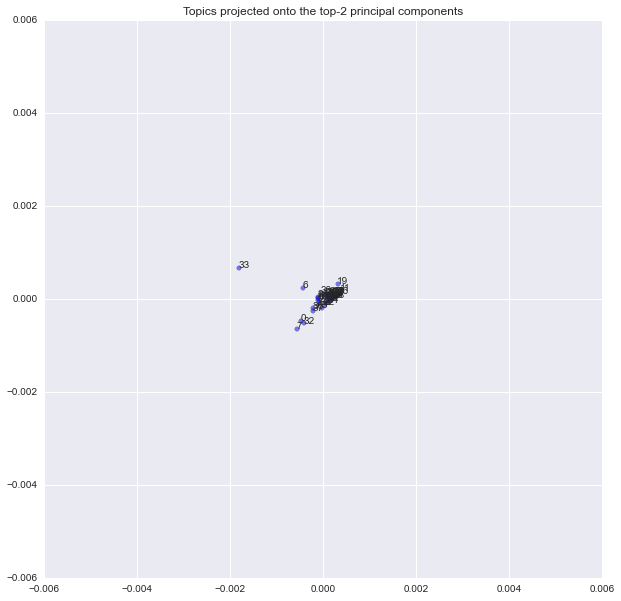

In [40]:
def drawTopicScatter(topicids, num_docs, pc_1, pc_2):
    """
       Draw scatterplot of topics
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    colors = np.random.rand(len(topicids))
    #Area of circles on a 0 to 200 scale
    areas = [np.pi*(30*n*1.0/np.max(num_docs))**2 for n in num_docs]
    #ax.scatter(pc_1, pc_2, s=areas, alpha=0.5)
    ax.scatter(pc_1, pc_2, alpha=0.5)
    for i, txt in enumerate(topicids):
        ax.annotate(txt, (pc_1[i],pc_2[i]))
    plt.title('Topics projected onto the top-2 principal components')
    plt.show()
#
drawTopicScatter(df['topicid'], df['num_docs'], df['pc_1'], df['pc_2'])

#### t-SNE projections

In [41]:
sql = """
    select
        t1.*,
        t2.num_docs
    from
    (
        select
            topic_num_plus1 - 1 as topicid,
            topic_prob_arr
        from
            YOUR_SCHEMA.twenty_news_groups_lda_topic_probs
    )t1,
    (
        -- For each topic, find the number of documents in which it is the majority
        select
            topicid,
            count(distinct docid) as num_docs
        from
        (
            select
                docid,
                topicid,
                rank() over(partition by docid order by count desc) as rank
            from
            (
                select
                    docid,
                    topicid,
                    count(*) as count
                from
                (
                    select
                        docid,
                        unnest(topic_assignment) as topicid
                    from
                        YOUR_SCHEMA.twenty_news_groups_lda_results
                )q1
                group by docid, topicid
            )q2
        )q3
        where rank=1
        group by topicid
    )t2
    where t1.topicid = t2.topicid
"""
tsne_df = psql.read_sql(sql, conn)
conn.commit()

In [42]:
import sklearn
from sklearn.manifold import TSNE
tsne_mat = np.array(tsne_df['topic_prob_arr'].tolist())
topics_proj = TSNE(random_state=20150912).fit_transform(tsne_mat)

In [43]:
def scatterTSNE(title, mat, labels, sizes):
    """
        Based on https://github.com/oreillymedia/t-SNE-tutorial
    """
    import matplotlib.patheffects as PathEffects
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", len(labels)))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sizes = [np.pi*(30.0*s/np.max(sizes))**2 for s in sizes]
    sc = ax.scatter(mat[:,0], mat[:,1], lw=0, s=sizes,
                    c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(len(labels)):
        # Position of each label.
        xtext, ytext = mat[i, :]
        txt = ax.text(xtext, ytext, '{0}'.format(labels[i]), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title(title, fontsize=24)
    plt.show()

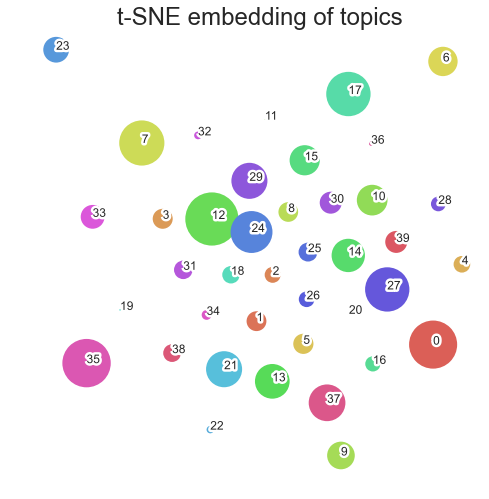

In [44]:
scatterTSNE('t-SNE embedding of topics', topics_proj, tsne_df['topicid'].tolist(), tsne_df['num_docs'].tolist())

### 4. Visualize Topic Clouds

In [51]:
sql = """
    drop table if exists YOUR_SCHEMA.twenty_news_groups_lda_topic_desc cascade;
    select 
        madlib.lda_get_topic_desc( 
        'YOUR_SCHEMA.twenty_news_groups_lda_mdl', -- model table
        'YOUR_SCHEMA.twenty_news_groups_lda_input_vocabulary', -- word_id to word mapping (vocabulary table)
        'YOUR_SCHEMA.twenty_news_groups_lda_topic_desc', -- output table
        50 -- top_k words for the given topic
    );
"""
psql.execute(sql, conn)
conn.commit()

In [52]:
sql = """
    select 
        topicid - 1 as topicid,
        wordid,
        prob,
        word
    from 
        YOUR_SCHEMA.twenty_news_groups_lda_topic_desc 
    order by 
        topicid, prob desc;
"""
df_topic_dist = psql.read_sql(sql, conn)
conn.commit()
df_topic_dist.head()

topicid  wordid      prob    word
0  0        13828   0.010493  one   
1  0        8071    0.010357  god   
2  0        5629    0.008588  doe   
3  0        14497   0.007465  people
4  0        19614   0.007329  think

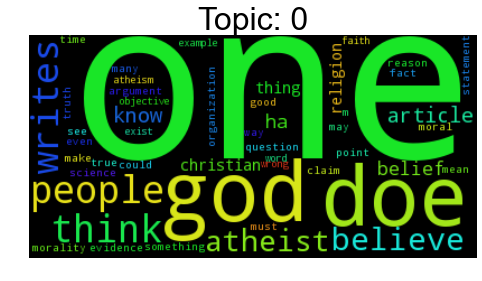

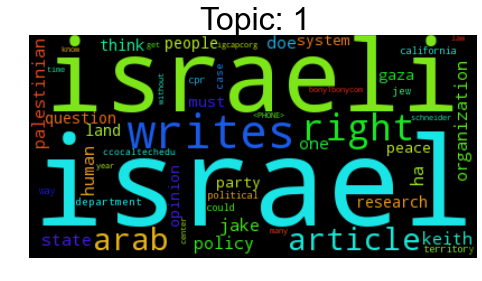

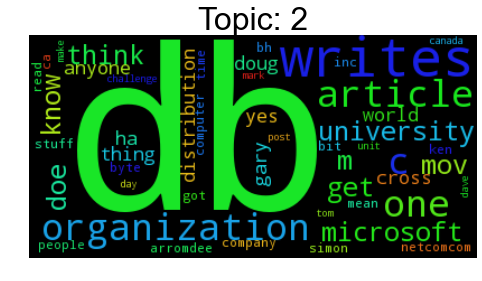

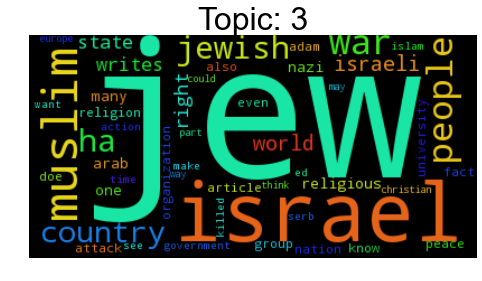

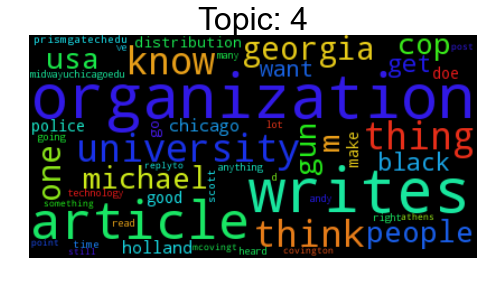

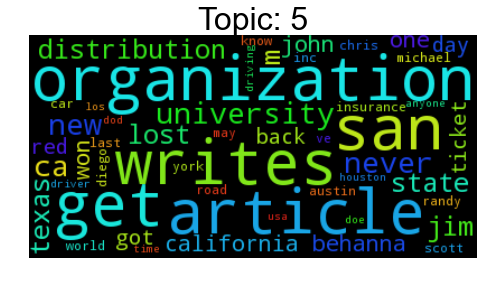

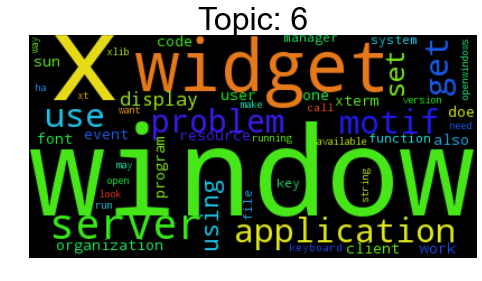

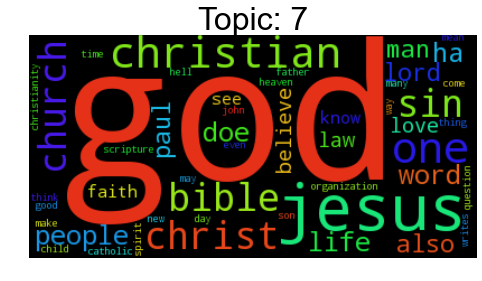

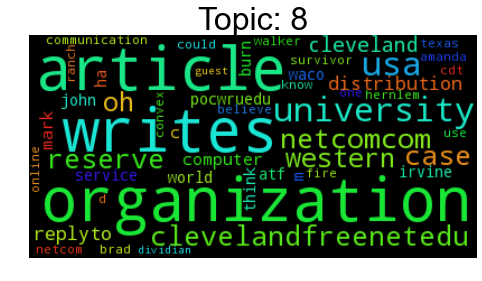

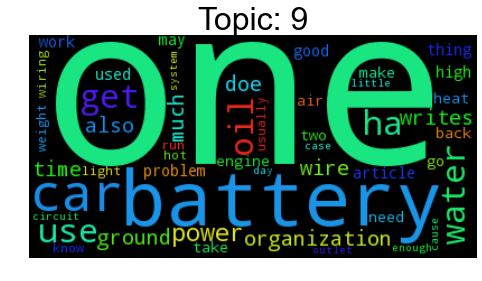

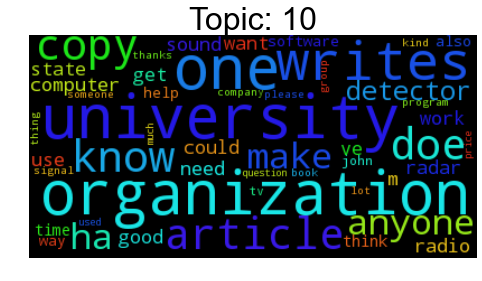

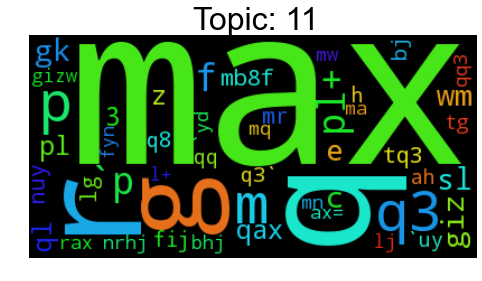

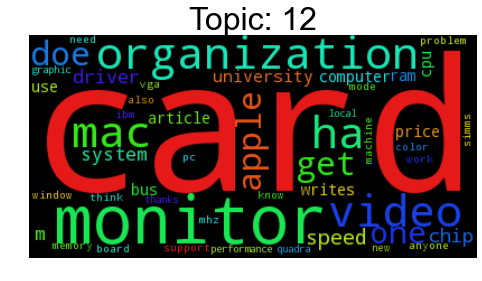

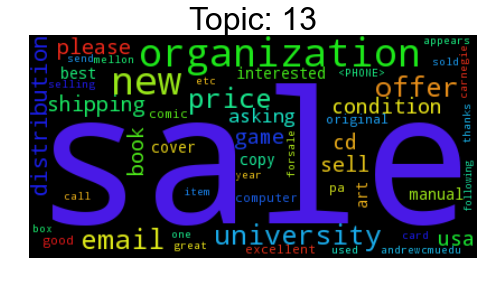

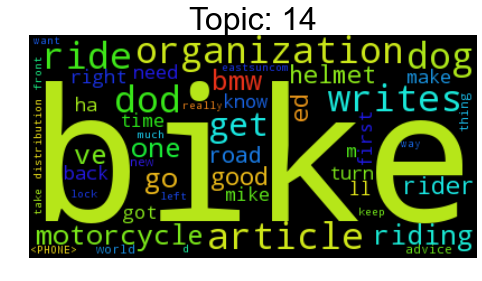

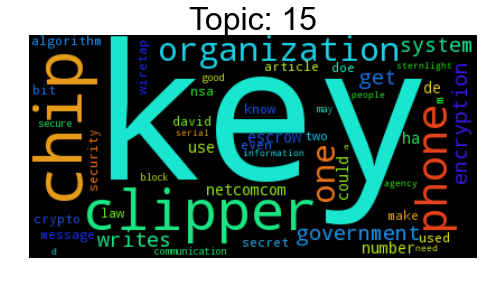

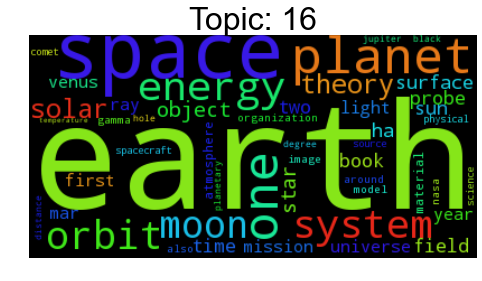

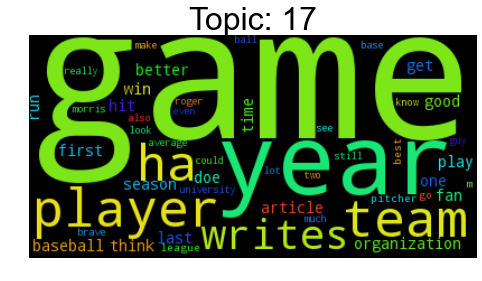

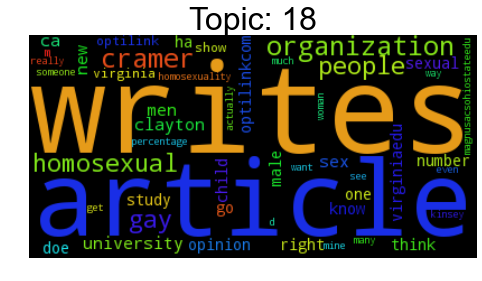

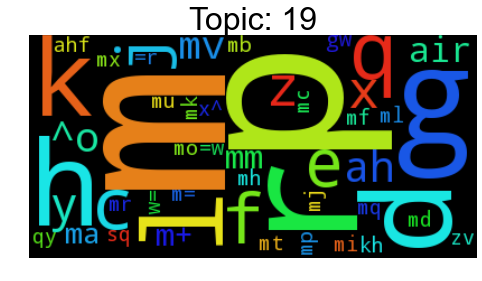

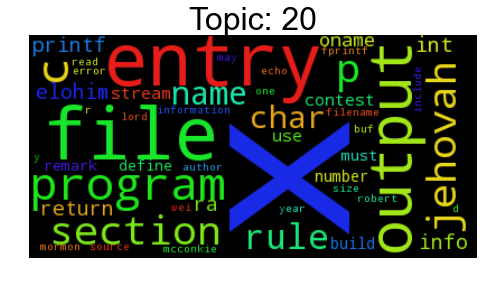

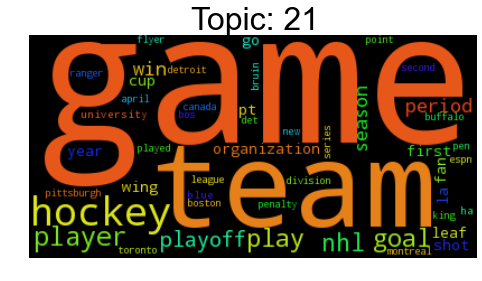

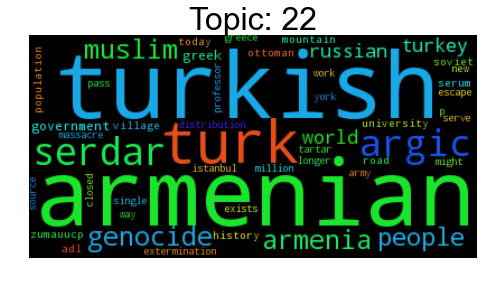

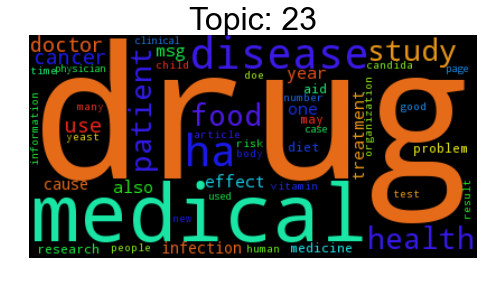

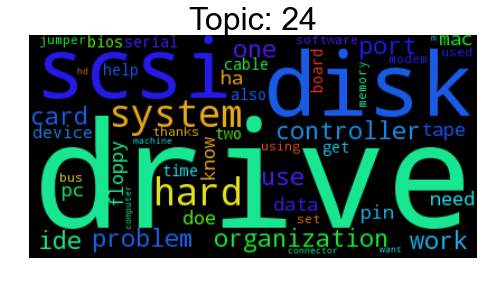

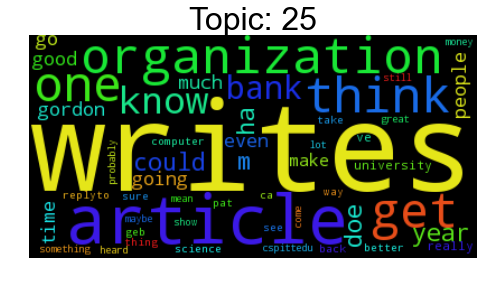

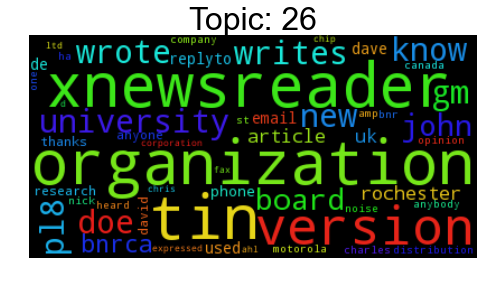

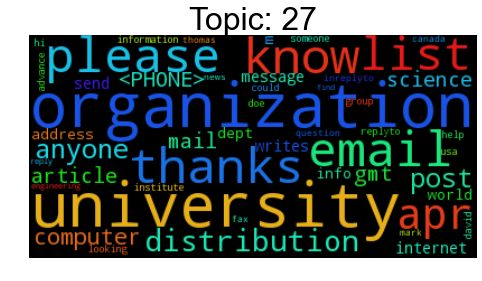

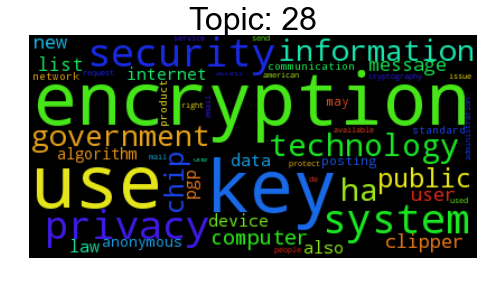

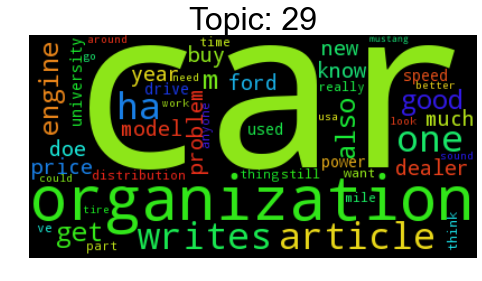

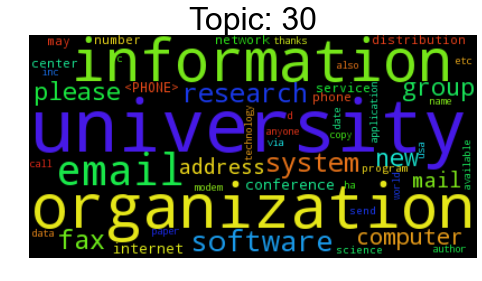

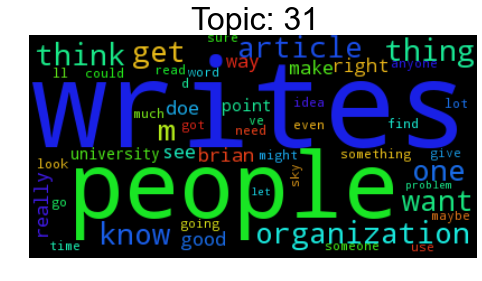

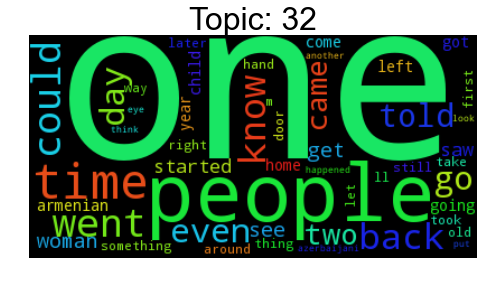

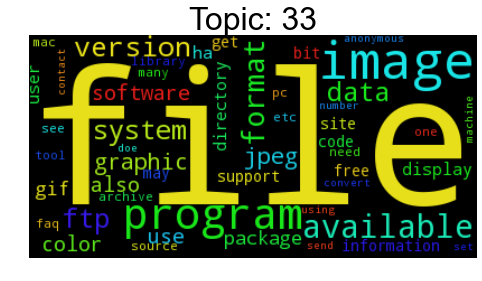

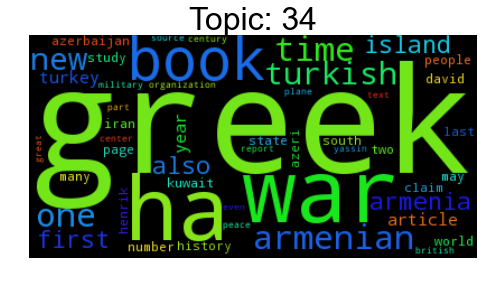

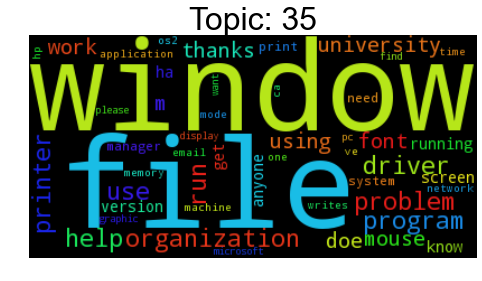

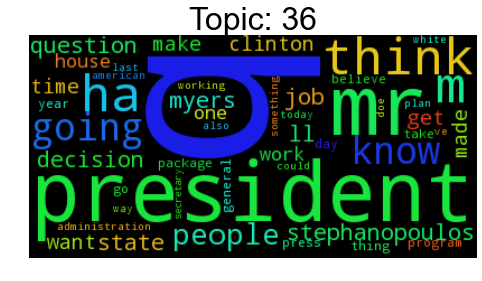

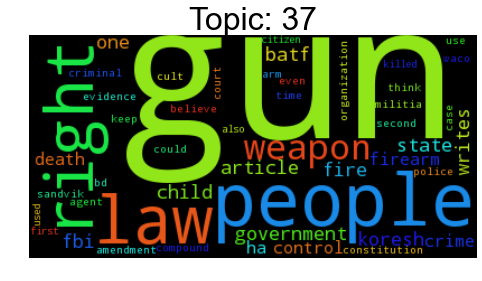

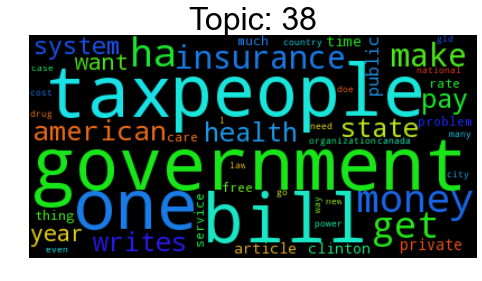

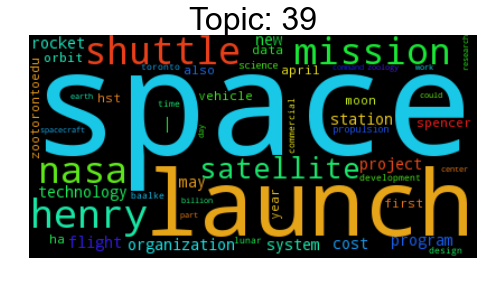

In [53]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """ https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html """
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def showTopicCloud(toks, topic):
    """
        Show tagcloud for the supplied dataframe containing tokens and their weights
    """ 
    wordcloud = WordCloud().generate_from_frequencies(toks)
    plt.figure(figsize=(8,5))
    #Turn this on if you'd rather have wordclouds in grayscale
    #plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
    plt.imshow(wordcloud)   
    plt.axis("off")
    plt.title('Topic: {0}'.format(topic), fontsize=32, color = '#000000')
    plt.show()
    
for topic in list(set(df_topic_dist['topicid'].tolist())):
    toks = df_topic_dist[df_topic_dist.topicid==topic][['word', 'prob']].values.tolist()
    showTopicCloud(toks, topic)

### 5. Create a table with News Groups data, with an additional column representing the predominant topic

In [56]:
sql = """
    --1) Define UDF to find most frequently occurring element in a list
    create or replace function YOUR_SCHEMA.most_frequent_item(arr int[])
    returns int
    as
    $$
        from collections import defaultdict
        from operator import itemgetter
        result = defaultdict(int)
        for k in arr:
            result[k]+=1
        return max(result.iteritems(), key=itemgetter(1))[0]
    $$language plpythonu;
    
    --2) Invoke the UDF to append a column containing the predominant topic for this recid
    drop table if exists YOUR_SCHEMA.twenty_news_groups_w_dominant_topic cascade;
    create table YOUR_SCHEMA.twenty_news_groups_w_dominant_topic
    as
    (
        select
            YOUR_SCHEMA.most_frequent_item(t2.topic_assignment) as dominant_topic,
            t1.*
        from
            YOUR_SCHEMA.twenty_news_groups t1,
            YOUR_SCHEMA.twenty_news_groups_lda_results t2
        where t1.doc_id = t2.docid
    ) distributed by (doc_id);
"""
psql.execute(sql, conn)
conn.commit()
df = psql.read_sql("""select * from YOUR_SCHEMA.twenty_news_groups_w_dominant_topic limit 40;""", conn)
display(df)
conn.commit()

dominant_topic  doc_id  \
0   14              3213     
1   9               3245     
2   12              2607     
3   17              3848     
4   0               37       
5   15              4309     
6   12              913      
7   30              2559     
8   27              8822     
9   2               140      
10  38              4061     
11  12              1642     
12  6               1893     
13  25              1408     
14  33              396      
15  23              5317     
16  18              7140     
17  15              4305     
18  23              5063     
19  16              5614     
20  3               6931     
21  6               10573    
22  35              770      
23  17              3633     
24  25              3963     
25  21              4091     
26  0               110      
27  1               142      
28  9               3365     
29  21              4130     
30  13              2661     
31  29              2693     
32  9               5316     
33  30              594      
34  38              7180     
35  30              1202     
36  35              1701     
37  31              297      
38  8               6252     
39  21              3855     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     